In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from data_processing.preprocessing import *

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utils.plotting import *
from model.cnn import *
from model.gru import *
from model.lstm import *
from model.unet import *
from model.transformer import *
from model.metrics import *

In [2]:
#import data
bnp_data = pd.read_csv("../cleaned_data.csv")
bnp_data = add_features(bnp_data, window_sizes=[5, 10])

In [3]:
features=['Adj Close', 'Close', 'Volume','Log Return','ma_close_10','ma_volume_5']

In [4]:
gap = 100  # Gap between each subset

total_samples = len(bnp_data)
train_size = int(0.58 * total_samples)
test_size = int(0.17 * total_samples)
validation_size = int(0.17 * total_samples)

train,test,validation=data_splitting(bnp_data,train_size,test_size,validation_size,gap)

In [5]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Scaler for the target to inverse transform y_pred 
target = train[['Adj Close']]
scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target)

# Scaler for the training dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[features])
scaled_train = pd.DataFrame(scaled_train, columns=features)

# Applying the scaler of the training set onto test and validation set
scaled_test = scaler.transform(test[features])
scaled_test = pd.DataFrame(scaled_test, columns=features)

scaled_validation = scaler.transform(validation[features])
scaled_validation = pd.DataFrame(scaled_validation, columns=features)

In [6]:
timesteps = 10
X_train, y_train = create_sequences(scaled_train, target_column='Adj Close', timesteps=timesteps)
X_test, y_test = create_sequences(scaled_test, target_column='Adj Close', timesteps=timesteps)
X_validation, y_validation = create_sequences(scaled_validation, target_column='Adj Close', timesteps=timesteps)

<h2>Forecast Horizons</h2>

In [7]:
horizon=30
timesteps=10

In [8]:
def create_multistep_sequences(data, target_column, timesteps, forecast_horizon):
    """
    Creates sequences for forecasting multiple steps into the future.
    :param data: Input DataFrame
    :param target_column: Column to forecast
    :param timesteps: Number of timesteps in each sequence
    :param forecast_horizon: How far into the future to predict
    :return: Tuple of (X, y)
    """
    X, y = [], []
    for i in range(len(data) - timesteps - forecast_horizon + 1):
        X.append(data.iloc[i:i + timesteps].values)
        y.append(data.iloc[i + timesteps + forecast_horizon - 1][target_column])
    return np.array(X), np.array(y)

X_train, y_train = create_multistep_sequences(scaled_train, target_column='Adj Close', timesteps=timesteps,forecast_horizon=horizon)
X_test, y_test = create_multistep_sequences(scaled_test, target_column='Adj Close', timesteps=timesteps,forecast_horizon=horizon)
X_validation, y_validation = create_multistep_sequences(scaled_validation, target_column='Adj Close', timesteps=timesteps,forecast_horizon=horizon)

In [ ]:
# Build and train the LSTM model
model = build_transformer((X_train.shape[1], X_train.shape[2])
, embed_dim=64 , num_heads=4, ff_dim=128, num_layers=2, dropout_rate=0.1) # Input shape (timesteps, features)
model.summary()

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores weights from the best epoch
)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 64)    │      1,216 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10, 64)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 5, 64)     │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 128)    │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 128)    │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 2, 128)    │          0 │ dropout_1[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2, 256)    │     98,560 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2, 256)    │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1, 256)    │          0 │ dropout_2[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1, 512)    │    393,728 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1, 512)    │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 2, 512)    │          0 │ dropout_3[0][0]   │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 768)    │          0 │ up_sampling1d[0]… │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 2, 256)    │    590,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2, 256)    │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_1     │ (None, 4, 256)    │          0 │ dropout_4[0][0]   │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d      │ (None, 5, 256)    │          0 │ up_sampling1d_1[… │
│ (ZeroPadding1D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 5, 384)    │          0 │ zero_padding1d[0… │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 5, 128)    │    147,584 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,293,441 (4.93 MB)

 Trainable params: 1,293,441 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1353 - mae: 0.1463 - val_loss: 0.1368 - val_mae: 0.2669
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0483 - mae: 0.0952 - val_loss: 0.0810 - val_mae: 0.2174
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0289 - mae: 0.0903 - val_loss: 0.0554 - val_mae: 0.1852
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0230 - mae: 0.0945 - val_loss: 0.0631 - val_mae: 0.2079
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0179 - mae: 0.0898 - val_loss: 0.0702 - val_mae: 0.2229
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0178 - mae: 0.0929 - val_loss: 0.0864 - val_mae: 0.2501
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0154 - mae: 0.0908 - val_loss: 0.0498 - val_mae: 0.1881
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0139 - mae: 0.0865 - val_loss: 0.0694 - val_mae: 0.2254
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/

In [11]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 4.9132
NSE: 0.6320


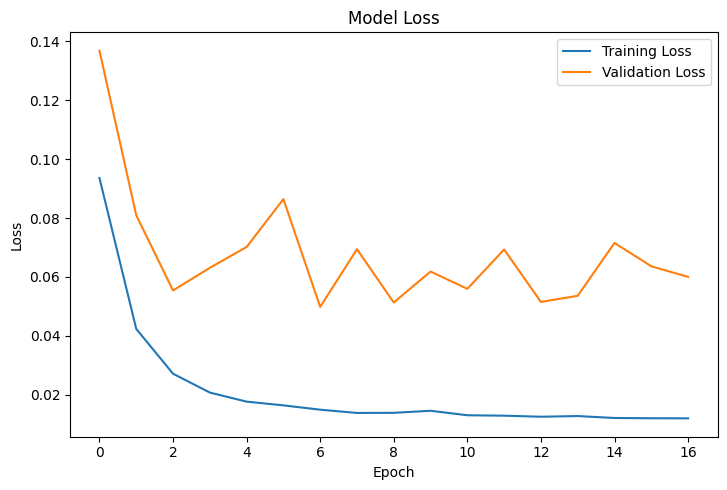

In [12]:
plot_learning_curves(history)

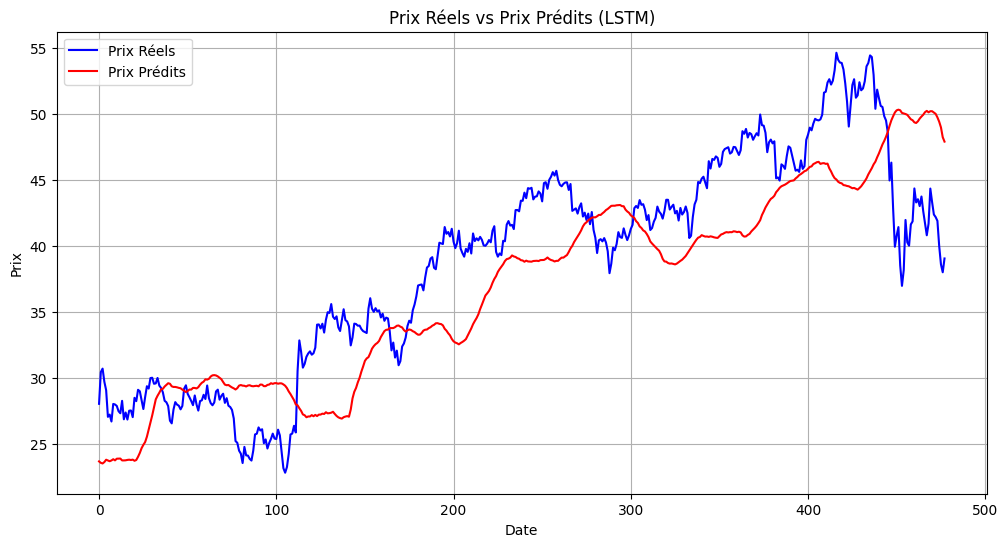

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (LSTM)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()


In [14]:
def persistence_model(y_actual, horizon):
    """
    Implements a persistence model.
    :param y_actual: Array of true values
    :param horizon: Forecast horizon
    :return: Array of predictions
    """
    y_pred = y_actual[:-horizon]
    return y_pred

# Example usage:
# True values for comparison
true_values = y_test[horizon:]  # Exclude first 'horizon' values
y_pred = persistence_model(y_test, horizon)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(true_values.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

RMSE: 4.7568
NSE: 0.6347


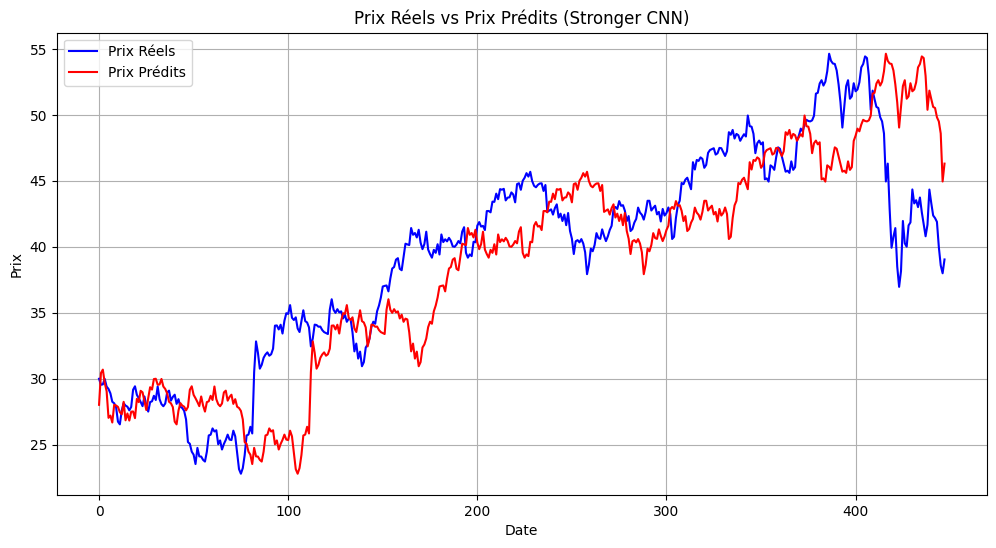

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (Stronger CNN)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()